In [28]:
import tensorflow as tf
from functionsTF import *

%load_ext autoreload
%autoreload 2

import time
import numpy as np
import matplotlib
%matplotlib inline
import pylab as plt
import seaborn as sns
#Imports for visualization
import PIL.Image
from io import BytesIO
from IPython.display import clear_output, Image, display

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


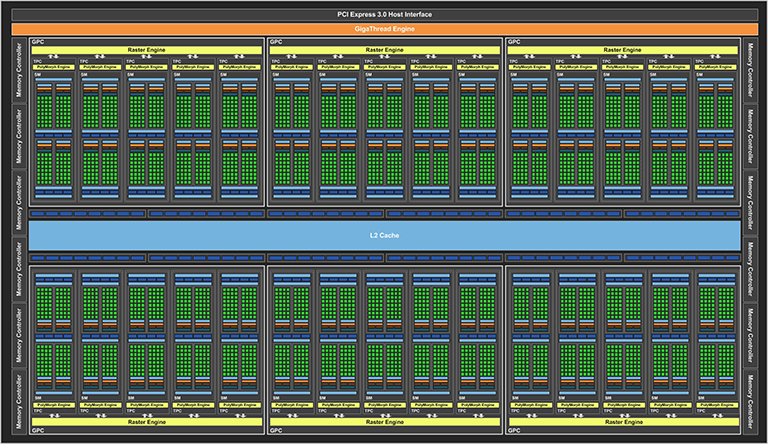

In [29]:
Image(filename=os.path.expanduser('~/Dropbox/ICL-2014/Presentations/2016-08-16-GPU/architecture.png'))

#libraries stats: https://twitter.com/fchollet/status/765212287531495424/photo/1?ref_src=twsrc%5Etfw

In [30]:
class Tfnet:

    def __init__(self, N=400, T=400, disp=False, spikeMonitor=False, input=None, tauv=15, 
                 sG=10, device='/gpu:0', both=False, BLOCK_PLAST=4000):
        self.N = N
        self.T = T
        self.disp = disp
        self.spikeMonitor = spikeMonitor
        self.tauv = tauv
        self.sG = sG
        self.device = device
        self.both = both
        self.BLOCK_PLAST = BLOCK_PLAST
        NUM_CORES = 50
        self.sess = tf.InteractiveSession(config=tf.ConfigProto(inter_op_parallelism_threads=NUM_CORES,
                   intra_op_parallelism_threads=NUM_CORES))
        if input is None:
            self.input = np.ones((T,1), dtype='int32')

    def to_JSON(self):
        return json.dumps(self, default=lambda o: o.__dict__,
                          sort_keys=True, indent=4)
    
    def DisplayArray(self, a, fmt='jpeg', rng=[0,1], text=""):
        """Display an array as a picture."""
        a = (a - rng[0])/float(rng[1] - rng[0])*255
        a = np.uint8(np.clip(a, 0, 255))
        f = BytesIO()
        PIL.Image.fromarray(np.uint8(plt.cm.YlGnBu_r(a)*255)).save(f, fmt)
        display(Image(data=f.getvalue()))
        print(text)
    
    def init_float(self, shape, name):
        return tf.Variable(tf.zeros(shape), name=name)
    
    def variable_summaries(self, var, name):
        """Attach a lot of summaries to a Tensor."""
        with tf.name_scope('summaries'):
            mean = tf.reduce_mean(var)
            tf.scalar_summary('mean/' + name, mean)
            with tf.name_scope('stddev'):
                stddev = tf.sqrt(tf.reduce_sum(tf.square(var - mean)))
            tf.scalar_summary('sttdev/' + name, stddev)
            tf.scalar_summary('max/' + name, tf.reduce_max(var))
            tf.scalar_summary('min/' + name, tf.reduce_min(var))
            tf.histogram_summary(name, var)
        return 0

    def runTFSimul(self):
        #################################################################################
        ### INITIALISATION
        #################################################################################
        N = self.N
        T = self.T
        with tf.device(self.device):
            dt = tf.placeholder(tf.float32, shape=(), name='dt')
            tauv = tf.placeholder(tf.float32, shape=(), name='tauv')
            sim_index = tf.placeholder(tf.int32, shape=(), name='sim_index')
    
            scaling = 1 / (1 / (2 * 2 / 0.25)) ** 0.5 * 70
    
            # Create variables for simulation state
            u =self.init_float([N, 1], 'u')
            v =self.init_float([N, 1], 'v')
            t = tf.Variable(0, dtype='float32')
            ind = tf.Variable(0, dtype='float32')
    
            LowSp =self.init_float([N, 1], 'bursting')
            vv =self.init_float([N, 1], 'spiking')

            vmean = tf.Variable(0, dtype='float32')
            umean = tf.Variable(0, dtype='float32')
            vvmean = tf.Variable(0, dtype='float32')
            vvmeanN1 = tf.Variable(0, dtype='float32')
            vvmeanN2 = tf.Variable(0, dtype='float32')
            imean = tf.Variable(0, dtype='float32')
            gammamean = tf.Variable(0, dtype='float32')
    
            # currents
            iBack = self.init_float([N, 1], 'iBack')
            iEff = self.init_float([N, 1], 'iEff')
            iGap = self.init_float([N, 1], 'iGap')
            iChem = self.init_float([N, 1], 'iChem')
            
            # synaptics connection
            conn = np.zeros([N, N], dtype='float32')
            sG = self.sG
            nbInCluster = int(N / 2)
            for i in range(N):
                for j in range(N):
                    conn[i][j] = ((i < (nbInCluster + sG)) & (j < (nbInCluster + sG))) \
                                 or ((i >= (nbInCluster - sG)) & (j >= (nbInCluster - sG)))
            allowedConnections = tf.Variable(conn)
            nbOfGaps = np.sum(conn)

            input = tf.cast(tf.constant(self.input), tf.float32)
    
            g0 = 7 / nbOfGaps ** 0.5
            wGap_init = (np.random.random_sample([N, N]).astype(np.float32)*(1-0.001)+0.001) * g0
            wII_init = np.ones([N, N], dtype=np.float32) * 500 / N / 0.25
    
            wGap = tf.Variable(wGap_init * conn)
            WII = tf.Variable(wII_init)
    
            FACT = 1
            ratio = 15
            A_LTD = 1e-0 * 4.7e-6 * FACT * N
            A_LTP = ratio * A_LTD

            # low constant noise
            TImean_init = tf.ones([N, 1]) * 30

            # stimulation
            TImean = 130.0
            TImean_simul = tf.ones([N, 1], dtype='float32') * TImean

            self.spikes = self.init_float([T, N], "spikes")

            subnet = tf.concat(0, [tf.ones([N//2, 1]), tf.zeros([N-N//2,1])])
            subnetout = tf.concat(0, [tf.zeros([N//2, 1]), tf.ones([N-N//2,1])])
            tauvSubnet = subnet * 15 + subnetout * self.tauv

        #################################################################################
        ## Computation
        #################################################################################
        with tf.device(self.device):
            with tf.name_scope('Currents'):
                # Discretized PDE update rules
                iChem_ = iChem + dt / 5 * (-iChem + tf.matmul(WII, tf.to_float(vv)))
    
                # current
                iBack_ = iBack + dt / 2 * (-iBack + tf.random_normal((N, 1), mean=0.0, stddev=1.0, dtype=tf.float32,
                                                                     seed=None, name=None))
                # iEff_ = iBack_ * scaling + tf.select(tf.greater(tf.ones([N, 1]) * t, 300), TImean_simul, TImean_init)
                input_ = tf.gather(input, sim_index)

                if self.both:
                    # input to both subnet
                    iEff_ = iBack_ * scaling + tf.select(tf.greater(tf.ones([N, 1]) * input_, 0), TImean_simul*2, TImean_init)
                else:
                    # input to both subnet
                    iEff_ = iBack_ * scaling + tf.select(tf.greater(subnet * input_, 0), TImean_simul * 2, TImean_init)

                iGap_ = tf.matmul(wGap, v) - tf.mul(tf.reshape(tf.reduce_sum(wGap, 0), (N, 1)), v)
    
                I_ = iGap_ + iChem_ + iEff_
    
            # IZHIKEVICH
            with tf.name_scope('Izhikevich'):
                ind_ = ind + 1
                # voltage
                v_ = v + dt / tauvSubnet * (tf.mul((v + 60), (v + 50)) - 20 * u + 8 * I_)
                # adaptation
                u_ = u + dt * 0.044 * (v_ + 55 - u)
                # spikes
                vv_ = tf.to_float(tf.greater(v_, 25.0))
                vvN1_ = tf.to_float(tf.greater(v_*subnet, 25.0))
                vvN2_ = tf.to_float(tf.greater(v_*subnetout, 25.0))
                # reset
                v_ = tf.mul(vv_, -40.0) + tf.mul((1 - vv_), v_)
                u_ = u_ + tf.mul(vv_, (50.0))
    
            # bursting
            with tf.name_scope('bursting'):
                LowSp_ = LowSp + dt / 10.0 * (vv_ * 10.0 / dt - LowSp)
                p = tf.to_float(tf.greater(LowSp_, 1.3))
    
            # plasticity
            with tf.name_scope('plasticity'):
                A = tf.matmul(p, tf.ones([1, N]))
                dwLTD_ = A_LTD * (A + tf.transpose(A))
    
                B = tf.matmul(vv_, tf.ones([1, N]))
                dwLTP_ = A_LTP * (tf.mul(tf.ones([N, N]) - 1 / g0 * wGap, B + tf.transpose(B)))
            
                dwGap_ = dt * (dwLTP_ - dwLTD_) * tf.cast((sim_index>self.BLOCK_PLAST), 
                                                          tf.float32)
                wGap_ = tf.mul(tf.clip_by_value(wGap + dwGap_, clip_value_min=0, clip_value_max=10 ** 10), allowedConnections)

            # monitoring
            with tf.name_scope('Monitoring'):
                vmean_ = tf.reduce_mean(v_)
                umean_ = tf.reduce_mean(u_)
                imean_ = tf.reduce_mean(I_)
                vvmean_ = tf.reduce_sum(tf.to_float(vv_))
                vvmeanN1_ = tf.reduce_sum(tf.to_float(vvN1_))
                vvmeanN2_ = tf.reduce_sum(tf.to_float(vvN2_))
                gammamean_ = tf.reduce_mean(wGap_)
    
            with tf.name_scope('Raster_Plot'):
                spike_update = tf.scatter_update(self.spikes, sim_index, tf.reshape((vv_), 
                                                                                    (N,)))
    
            # Operation to update the state
            step = tf.group(
                v.assign(v_),
                vv.assign(vv_),
                u.assign(u_),
                iBack.assign(iBack_),
                iEff.assign(iEff_),
                LowSp.assign(LowSp_),
                wGap.assign(wGap_),
                vmean.assign(vmean_),
                umean.assign(umean_),
                imean.assign(imean_),
                vvmean.assign(vvmean_),
                vvmeanN1.assign(vvmeanN1_),
                vvmeanN2.assign(vvmeanN2_),
            )
        self.sess.run(tf.initialize_all_variables())
        
        self.vm = []
        self.um = []
        self.vvm = []
        self.vvmN1 = []
        self.vvmN2 = []
        self.im = []
        self.gamma = []
        self.iEff = []
        t0 = time.time()
        for i in range(T):
            # Step simulation
            self.sess.run([step], feed_dict={dt: 0.25, tauv: self.tauv, sim_index: i})
            if self.spikeMonitor:
                feed = {dt: 0.25, tauv: 15, sim_index: i}
                self.sess.run(spike_update, feed_dict=feed)
            self.vvm.append(vvmean.eval())
            self.vvmN1.append(vvmeanN1.eval())
            self.vvmN2.append(vvmeanN2.eval())
            
            # Visualize every ... steps
            if i % 1 == 0:
                if self.disp:
                    clear_output(wait=True)
                    self.DisplayArray(wGap.eval(), rng=[0, 1.5 * g0], 
                                      text="%.2f ms" % (i*0.25))
                self.vm.append(vmean.eval())
                self.um.append(umean.eval())
                self.im.append(imean.eval())
                self.iEff.append(iEff.eval())
                self.gamma.append(gammamean.eval())
    
        print('%.2f' % (time.time() - t0))
        self.sess.close()
        del self.sess

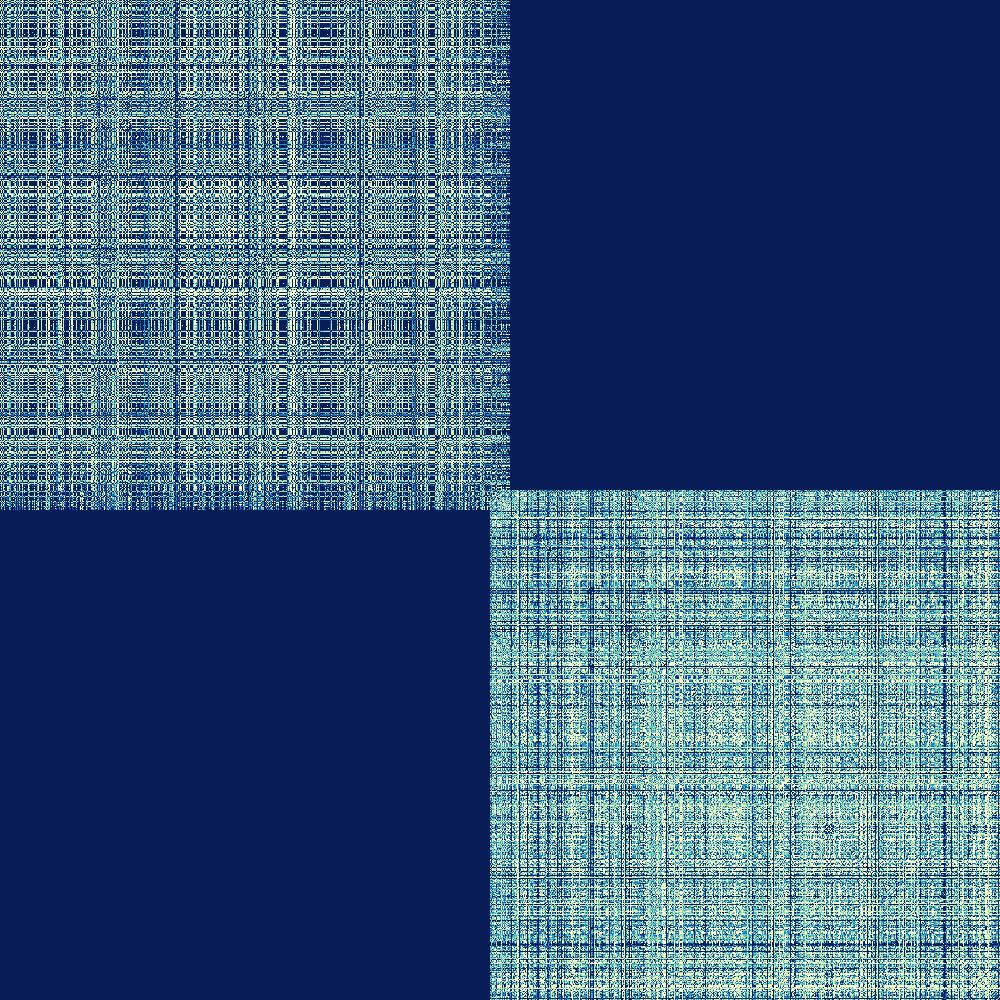

182.25 ms


In [ ]:
N = 1000
T = 1000

DEVICE = '/gpu:0'

disp = True # to display the weight matrix being updated
tauv = 45
sG = 10
both=False

### input 1: apple
gpu = Tfnet(N=N,T=T, disp=disp, tauv=tauv, sG=sG, device=DEVICE, both=both, BLOCK_PLAST=0)
np.random.seed(2)
apple = np.random.randint(0, 2, size=(T,1), dtype='int32')
gpu.input = apple
gpu.both = True
gpu.runTFSimul()
apple_out = gpu.vvm[-1000:]

0.167799895237


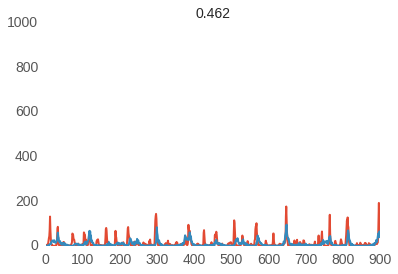

In [20]:
print(np.corrcoef(gpu.vvmN1, gpu.vvmN2)[0,1])

def plotSim(start=100, duration=1000):
    t0 = start
    t1 = t0 + duration
    plt.figure()
    plt.plot(gpu.vvmN1[t0:t1])
    plt.plot(np.array(gpu.vvmN2[t0:t1])*1)
    plt.title('%.3f'% (np.corrcoef(gpu.vvmN1[t0:t1], gpu.vvmN2[t0:t1])[0,1]))
    plt.ylim([0,1000])
    
plotSim(100,1000)
# plotSim(3000,1000)

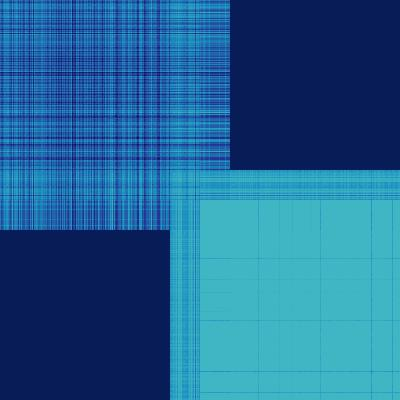

24.33


In [5]:
disp = False
tauv = 15
sG = 30

### input 1: apple
gpu = Tfnet(N=N,T=T, disp=disp, tauv=tauv, sG=sG, both=both)
np.random.seed(2)
apple = np.random.randint(0, 2, size=(T,1), dtype='int32')
gpu.input = apple
gpu.runTFSimul()
apple_out = gpu.vvm[-1000:]


### input 1: apple N200
gpu = Tfnet(N=N//2,T=T, disp=disp, tauv=tauv, sG=sG, both=both)
np.random.seed(2)
apple = np.random.randint(0, 2, size=(T,1), dtype='int32')
gpu.input = apple
gpu.runTFSimul()
apple_out_200 = gpu.vvm[-1000:]


### input 2: pear
gpu = Tfnet(N=N,T=T, disp=disp, tauv=tauv, sG=sG, both=both)
np.random.seed(3)
pear = np.random.randint(0, 2, size=(T,1), dtype='int32')
gpu.input = pear
gpu.runTFSimul()
pear_out = gpu.vvm[-1000:]

disp=False
tauv = 45
sG = 30

### input 1: apple
gpu = Tfnet(N=N,T=T, disp=disp, tauv=tauv, sG=sG, both=both)
np.random.seed(2)
apple = np.random.randint(0, 2, size=(T,1), dtype='int32')
gpu.input = apple
gpu.runTFSimul()
apple_out_45 = gpu.vvm[-1000:]


### input 1: apple N200
gpu = Tfnet(N=N//2,T=T, disp=disp, tauv=tauv, sG=sG, both=both)
np.random.seed(2)
apple = np.random.randint(0, 2, size=(T,1), dtype='int32')
gpu.input = apple
gpu.runTFSimul()
apple_out_200_45 = gpu.vvm[-1000:]


### input 2: pear
gpu = Tfnet(N=N,T=T, disp=disp, tauv=tauv, sG=sG, both=both)
np.random.seed(3)
pear = np.random.randint(0, 2, size=(T,1), dtype='int32')
gpu.input = pear
gpu.runTFSimul()
pear_out_45 = gpu.vvm[-1000:]

(0, 100)

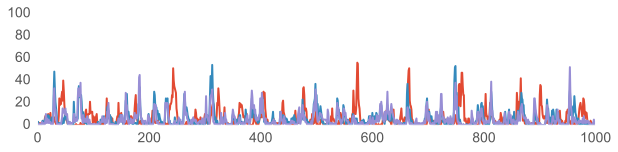

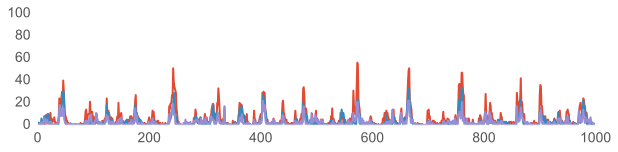

In [6]:
plt.figure(figsize=(10,2))
plt.plot(apple_out)
plt.plot(pear_out)
plt.plot(pear_out_45)
plt.ylim([0,100])

plt.figure(figsize=(10,2))
plt.plot(apple_out)
plt.plot(apple_out_200)
plt.plot(apple_out_200_45)
plt.ylim([0,100])

In [12]:
sp = tf.convert_to_tensor(gpu.spikes).eval()
plt.figure(figsize=(12,4))
extent=[0,T,0,N]
plt.imshow(sp.transpose(), extent=extent, aspect=0.3*(extent[1] - extent[0]) / (
            extent[3] - extent[2]))

ValueError: Cannot evaluate tensor using `eval()`: No default session is registered. Use `with sess.as_default()` or pass an explicit session to `eval(session=sess)`

In [ ]:
plt.figure(figsize=(10,2))
plt.plot(gpu.vvm[-1000:])
plt.figure(figsize=(10,2))
plt.plot(apple)
plt.figure(figsize=(10,2))
plt.plot(np.array(gpu.gamma)*N**2)

In [ ]:
fig = plt.figure(figsize=(9,2))
ax0 = fig.add_subplot(141)
ax1 = fig.add_subplot(142)
ax2 = fig.add_subplot(143)
ax3 = fig.add_subplot(144)

ax0.plot(vm)

ax1.plot(um)
ax1.set_title('adaptation')

ax2.plot(vvm)
ax2.set_title('spiking')

ax3.plot(im)
ax3.set_title('current')

In [ ]:
T=100
np.random.seed(2)
apple = np.random.randint(0,2, size=(T,1))
np.random.seed(3)
pear = np.random.randint(0,2, size=T)


fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ax.plot(apple, c='r')
ax.set_ylim([0,1.2])
ax.set_title('Apple')

ax2.plot(pear, c='y')
ax2.set_ylim([0,1.2])
ax2.set_title('Pear')

In [4]:
_apple = np.random.randint(0, 2, size=(T,1), dtype='int32')
apple = tf.constant(_apple)

input = tf.constant([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
apple[0,100]

<tf.Tensor 'Squeeze:0' shape=() dtype=int32>

In [5]:
tf.gather(apple, 10)

<tf.Tensor 'Gather:0' shape=(1,) dtype=int32>

In [12]:
tf.ones([N,1])

<tf.Tensor 'ones_10:0' shape=(400, 1) dtype=float32>

In [13]:
tf.concat(0, [tf.ones([100,1]), tf.ones([100,1])])

<tf.Tensor 'concat_1:0' shape=(200, 1) dtype=float32>

In [24]:
t1 = tf.ones([2,3])
t2 = tf.zeros([2,3])
tf.concat(0, [t1, t2])


<tf.Tensor 'concat_20:0' shape=(4, 3) dtype=float32>